# Snowfall Retrievals CSU X-Band Radar March 14, 2022

## Imports

In [1]:
import glob
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt
import pyart
import xarray as xr


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Setup Helper Functions

In [3]:
def snow_rate(radar, SWE_ratio, A, B):
    """
    Takes a given Snow Water Equivilent ratio (SWE_ratio), A and B value
    for the Z-S relationship and creates a radar field similar to DBZ
    showing the radar estimated snowfall rate in mm/hr. Then the given
    SWE_ratio, A and B are stored in the radar metadata for later 
    reference.   

    """
    # Setting up for Z-S relationship:
    snow_z = radar.fields['DBZ']['data'].copy()
    # Convert it from dB to linear units
    z_lin = 10.0**(radar.fields['DBZ']['data']/10.)
    # Apply the Z-S relation.
    snow_z = SWE_ratio * (z_lin/A)**(1./B)
    # Add the field back to the radar. Use reflectivity as a template
    radar.add_field_like('DBZ', 'snow_z',  snow_z,
                         replace_existing=True)
    # Update units and metadata
    radar.fields['snow_z']['units'] = 'mm/h'
    radar.fields['snow_z']['standard_name'] = 'snowfall_rate'
    radar.fields['snow_z']['long_name'] = 'snowfall_rate_from_z'
    radar.fields['snow_z']['valid_min'] = 0
    radar.fields['snow_z']['valid_max'] = 500
    radar.fields['snow_z']['swe_ratio'] = SWE_ratio
    radar.fields['snow_z']['A'] = A
    radar.fields['snow_z']['B'] = B
    return radar

## Define the Point Retrievals

In [4]:
# Define the splash locations [lon,lat]
sail = [-106.987, 38.9586]
kettle_ponds = [-106.9731488, 38.9415427]
brush_creek = [-106.920259, 38.8596282]
avery_point = [-106.9965928, 38.9705885]
pumphouse_site = [-106.9502476, 38.9226741]
roaring_judy = [-106.8530215, 38.7170576]

## Read Data + Subset at Points

In [6]:
for file in sorted(glob.glob("*nc")):
    radar = pyart.io.read(file)
    #-------------------------------------------------------------------------
    # Add in the extra fields to the radar object before extracting the column
    #-------------------------------------------------------------------------
    # Calculate estimated rainfall rate from reflectivty
    #rain = pyart.retrieve.qpe.est_rain_rate_z(radar)
    # Add the estimated rainfall rate back into the radar object
    #radar.add_field('est_rainfall_rate', rain)
    # Call Matt's Z-S function with the constants he used
    radar = snow_rate(radar, 8.5, 28, 1.44)
    #-------------------------------------------------------------------------
    column = pyart.util.columnsect.get_field_location(radar, avery_point[1], avery_point[0])
    # Add a datetime dimension to the xarray radar column
    dt = datetime.datetime.strptime(column.date + ' ' + column.time[:-1],
                                    "%Y-%m-%d %H:%M:%S")
    coor_ad = column.assign_coords(date=dt.timestamp())
    ncolumn = coor_ad.expand_dims('date')
    # Make sure there are no duplicate height indices
    index = np.unique(column['height'], return_index=True)
    ncolumn = ncolumn.isel(height=index[1])
    basecolumn = ncolumn.isel(height=index[1][0])
    # append to the xarray dataset list
    ds_all.append(ncolumn)
    ds_base.append(basecolumn)

### Merge our Datasets

In [7]:
# combine the xarry DataArrays
ds_height = xr.concat(ds_all, 'date')
ds = xr.concat(ds_base, 'date')

## Plot the Data

/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator


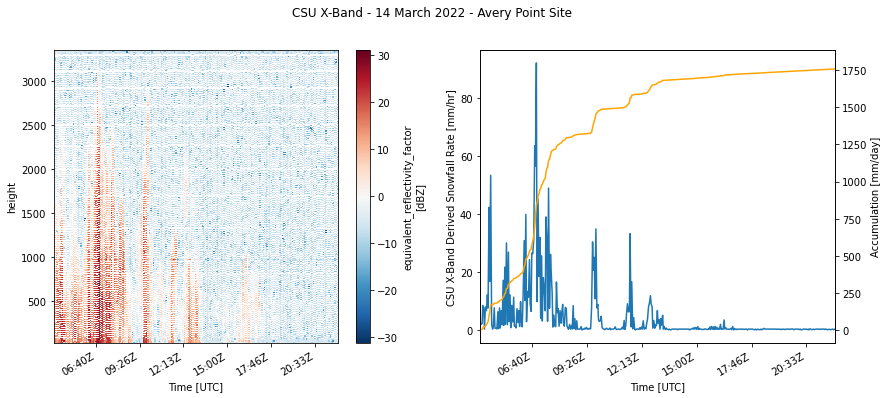

In [13]:
fig, axs = plt.subplots(1,2, figsize=[14,6])
fig.subplots_adjust(hspace=0.2, wspace=0.2)
#-----------------------------------------------
# Reflectivity over the Avery Point Site
#-----------------------------------------------
ds_height.DBZ.plot(x='date', ax=axs[0])
start = datetime.datetime(2022, 3, 14, 0, 0, 0)
end = datetime.datetime(2022, 3, 14, 18, 0, 0)
axs[0].set_xlim([start.timestamp(), end.timestamp()])
# Grab the xticks
xticks = axs[0].get_xticks()
# Define new ticks
newticks = []
for tick in xticks:
    newticks.append(datetime.datetime.
                    utcfromtimestamp(tick).strftime("%H:%MZ"))
axs[0].set_xticklabels(newticks)
axs[0].set_xlabel('Time [UTC]')
# format for dates
fig.autofmt_xdate()
#------------------------------------------------
# snow fall rate over the Avery Point Site
#------------------------------------------------
ds.snow_z.plot(x='date')
axs[1].set_xlim([start.timestamp(), end.timestamp()])
# Grab the xticks
xticks = axs[1].get_xticks()
# Define new ticks
newticks = []
for tick in xticks:
    newticks.append(datetime.datetime.
                    utcfromtimestamp(tick).strftime("%H:%MZ"))
axs[1].set_xticklabels(newticks)
axs[1].set_xlabel('Time [UTC]')
axs[1].set_ylabel("CSU X-Band Derived Snowfall Rate [mm/hr]")
# format for dates
fig.autofmt_xdate()
# calculate cumulative total - probably a function exists to do this
snow_total = [ds.snow_z[0]]
for i in range(1,ds.snow_z.shape[0]):
    snow_total.append((snow_total[i-1]+ds.snow_z[i]))
# make a twin axis
ax2 = axs[1].twinx()
ax2.plot(ds.date, snow_total, color='orange')
ax2.set_ylabel("Accumulation [mm/day]")

# set some titles
plt.suptitle("CSU X-Band - 14 March 2022 - Avery Point Site")
#axs[0].title("CSU-X Band - 14 March 2022 - Avery Point Site")
#axs[1].title("Derived Snowfall - 14 March 2022 - Avery Point Site")
plt.savefig("OBrien_SAIL_CSU_XBand_14March2022_AveryPoint")